<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/10xCRISPR/10xCRISPR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Fri May 28 21:40:15 UTC 2021


In [1]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 245, done.
remote: Total 245 (delta 0), reused 0 (delta 0), pack-reused 245
Receiving objects: 100% (245/245), 187.88 MiB | 27.77 MiB/s, done.
Resolving deltas: 100% (76/76), done.
Checking out files: 100% (64/64), done.


In [2]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 75kB/s 
     |████████████████████████████████| 133kB 35.0MB/s 
     |████████████████████████████████| 10.3MB 16.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 13.2MB 17.8MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 112kB 54.9MB/s 
     |████████████████████████████████| 1.2MB 32.5MB/s 
     |████████████████████████████████| 71kB 3.2MB/s 


In [3]:
# extract everything
!ls /content/BMGP_2020/data/10xCRISPR/*/*.tar.gz |xargs -n1 tar -xf

In [4]:
!gunzip /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/*

In [5]:
!cat /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xaa \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/xab > \
/content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix/matrix.mtx

In [6]:
!mv /content/BMGP_2020/data/10xCRISPR/cr/raw_feature_bc_matrix ./

In [7]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [8]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [9]:
path = "/content/counts_unfiltered/adata.h5ad"
raw_kb = anndata.read_h5ad(path)

In [10]:
# cellranger outputs genes by cells, we output cells by genes
mtx_path = "/content/raw_feature_bc_matrix/matrix.mtx"
mtx = mmread(mtx_path)
mmwrite("matrix_T.mtx", mtx.T)

In [11]:
!cut -d$'\t' -f 1 /content/raw_feature_bc_matrix/features.tsv > features_1_col.tsv

In [12]:
mat_path = "matrix_T.mtx"
bcs_path = "raw_feature_bc_matrix/barcodes.tsv"
ftr_path = "features_1_col.tsv"
t2g_path = "/content/BMGP_2020/references/10xCRISPR/kite/f2b.txt"

raw_cr = import_matrix_as_anndata(mat_path, bcs_path, ftr_path, t2g_path=t2g_path)
raw_cr.obs.index = raw_cr.obs.index.str.slice(0, 16).values

In [13]:
bcs_path = "/content/counts_filtered/cells_x_features.barcodes.txt"
df = pd.read_csv(bcs_path, names=["bcs"], header=None)

In [14]:
common = np.intersect1d(np.intersect1d(raw_cr.obs.index.values, raw_kb.obs.index.values), df.bcs.values)

In [15]:
kb = raw_kb[raw_kb.obs.index.isin(common)].copy()
cr = raw_cr[raw_cr.obs.index.isin(common)].copy()

In [16]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 3117 × 93
    var: 'feature_name'
AnnData object with n_obs × n_vars = 3117 × 36694
    var: 'gene_name'


In [17]:
common_genes = np.intersect1d(kb.var.index.values, cr.var.index.values)

In [18]:
kb = kb[:,kb.var.index.isin(common_genes)].copy()
cr = cr[:,cr.var.index.isin(common_genes)].copy()

In [19]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 3117 × 93
    var: 'feature_name'
AnnData object with n_obs × n_vars = 3117 × 93
    var: 'gene_name'


In [20]:
False in kb.obs.index.values == cr.obs.index.values

False

In [21]:
False in kb.var.index.values == cr.var.index.values

False

In [22]:
kb = kb[:,~kb.var.feature_name.str.contains("Non-Targeting")].copy()
cr = cr[:,~cr.var.gene_name.str.contains("Non-Targeting")].copy()

In [23]:
print(kb)
print(cr)

AnnData object with n_obs × n_vars = 3117 × 90
    var: 'feature_name'
AnnData object with n_obs × n_vars = 3117 × 90
    var: 'gene_name'


# Visualizations

In [24]:
labels = ["kb", "cr"]
colors = ["#e41a1c", "#377eb8"]

## Knee

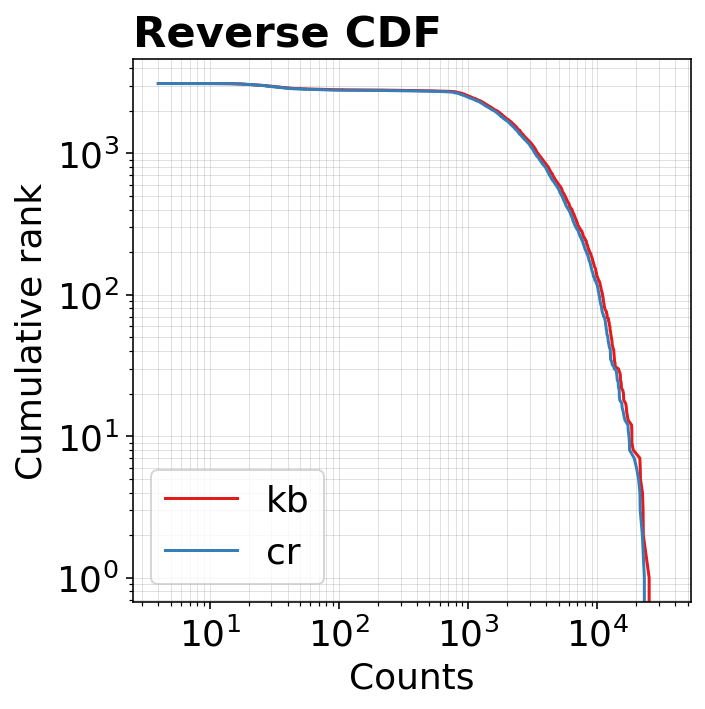

In [25]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cr.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

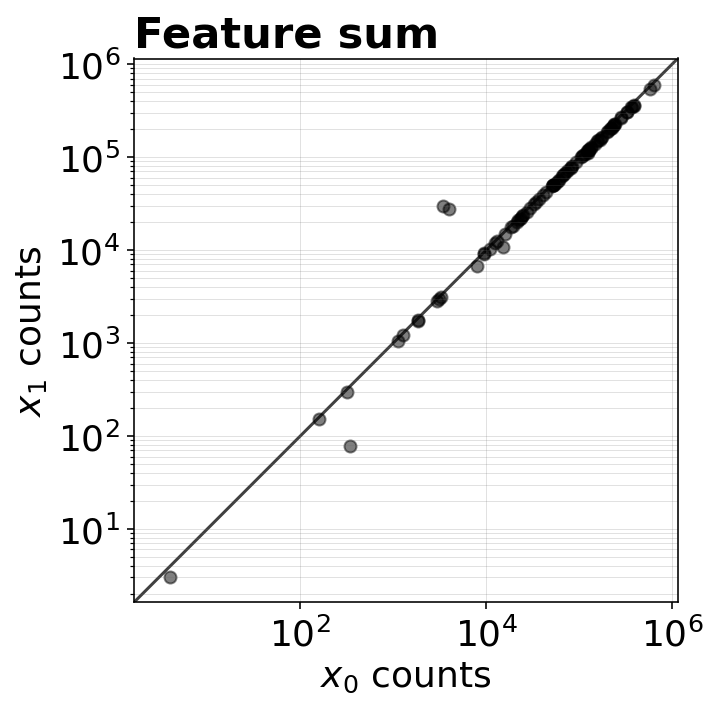

In [29]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [30]:
print(kb.var.iloc[np.argmax(np.abs(x1-x0).astype(int))])
print(cr.var.iloc[np.argmax(np.abs(x1-x0).astype(int))])

feature_name    ACE2-2
Name: ACE2-2, dtype: object
gene_name    ACE2-2
Name: ACE2-2, dtype: object


## pseudobulk - cell

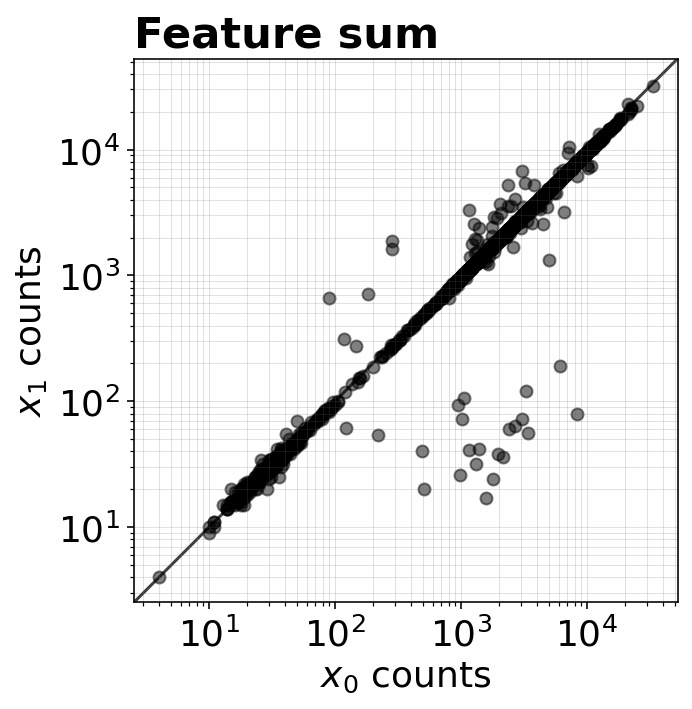

In [31]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cr.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

fig.show()

In [32]:
print(kb.obs.iloc[np.argmax(np.abs(x1-x0).astype(int))])
print(cr.obs.iloc[np.argmax(np.abs(x1-x0).astype(int))])

Series([], Name: CTGAGCGCATAAGATG, dtype: float64)
Series([], Name: CTGAGCGCATAAGATG, dtype: float64)


In [33]:
kb.var["feat_counts"] = nd(kb.X.sum(axis=0)).astype(int)
cr.var["feat_counts"] = nd(cr.X.sum(axis=0)).astype(int)

In [34]:
(kb.var-cr.var).query("feat_counts<0")

,feat_counts,feature_name,gene_name
feature_id,,,
EZR-1,-26256,NaN,NaN
PPIB-2,-23356,NaN,NaN


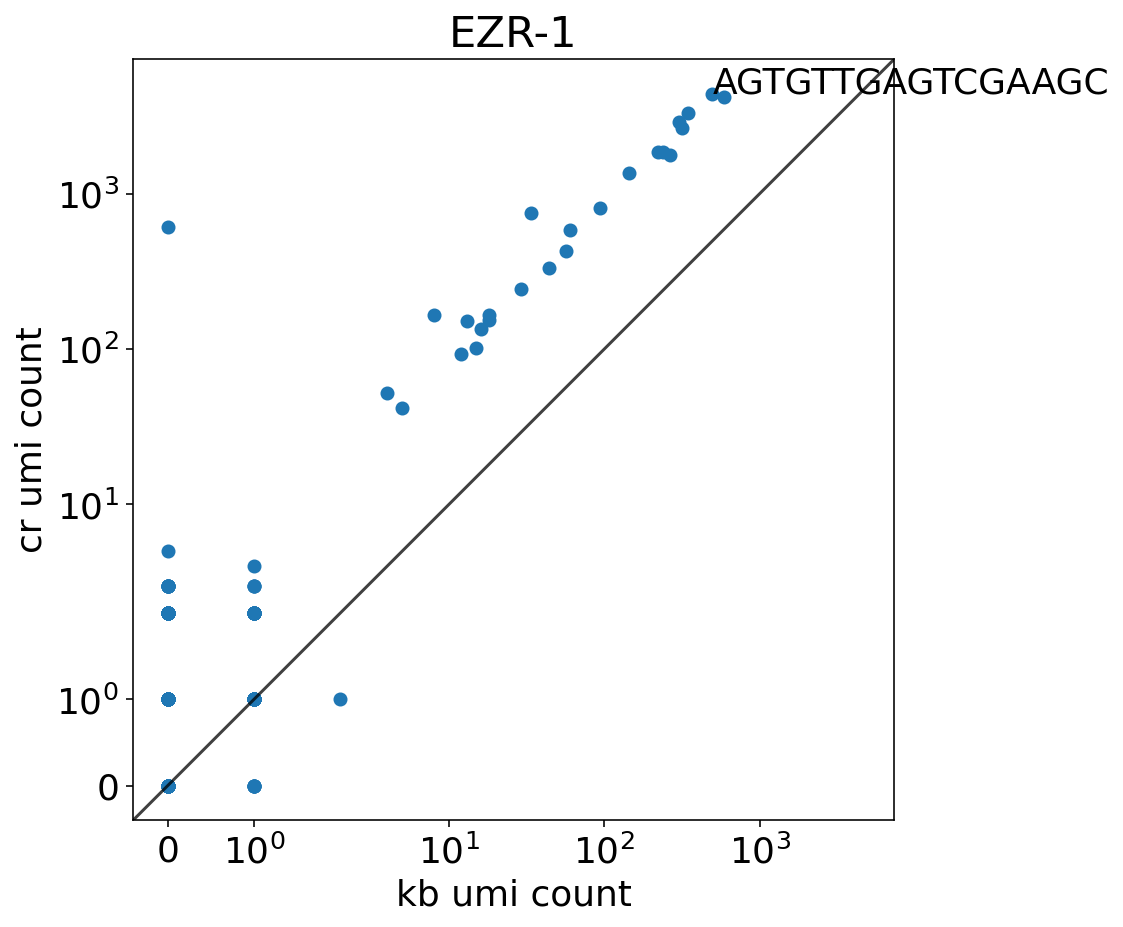

In [35]:
# look at just these two features
fig, ax = plt.subplots(figsize=(7,7))

feature = 'EZR-1'
x = nd(kb.X[:,kb.var.index.values == feature].todense())
y = nd(cr.X[:,cr.var.index.values == feature].todense())

ax.scatter(x,y)

ax.set(**{
    "xlabel": "kb umi count",
    "ylabel": "cr umi count",
    "xscale": "symlog",
    "yscale": "symlog",
    "title": feature

})
yex(ax)

for xx,yy,bc in zip(x,y, kb.obs.index.values):
  if bc == "AGTGTTGAGTCGAAGC":
    ax.text(xx,yy, bc)

fig.show()

In [36]:
print("kb : ", kb.X.todense()[:,kb.var.feature_name == "EZR-1"].sum())
print("cr : ", cr.X.todense()[:,cr.var.gene_name == "EZR-1"].sum())

kb :  3419.0
cr :  29675.0


In [38]:
print("kb : ", raw_kb.X[raw_kb.obs.index.values == "AGTGTTGAGTCGAAGC"].todense().sum())
print("cr : ", raw_cr.X[raw_cr.obs.index.values == "AGTGTTGAGTCGAAGC"].todense().sum())

kb :  3067.0
cr :  13326.0


In [39]:
amax = np.argmax(y-x)

In [42]:
print(kb.obs.index.values[amax])
print(cr.obs.index.values[amax])

AGTGTTGAGTCGAAGC
AGTGTTGAGTCGAAGC


In [43]:
y[amax], x[amax]

(4376.0, 496.0)

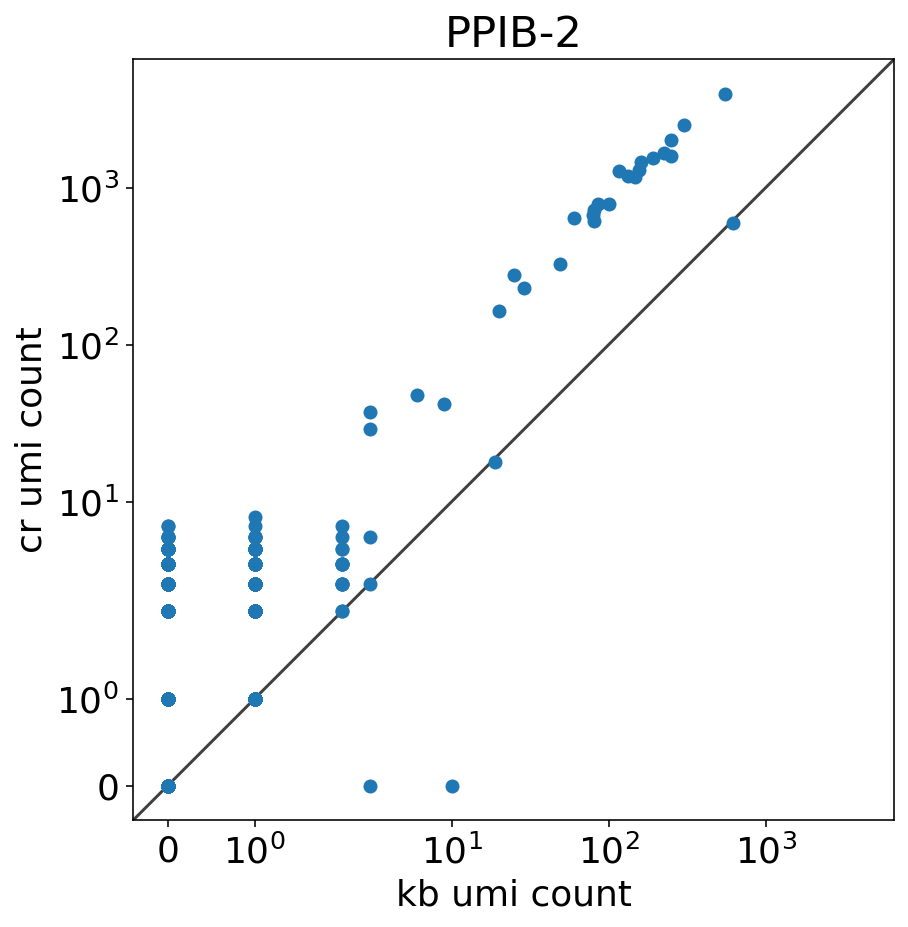

In [ ]:
#@title
# look at just these two features
fig, ax = plt.subplots(figsize=(7,7))

feature = 'PPIB-2'
x = nd(kb.X[:,kb.var.index.values == feature].todense())
y = nd(cr.X[:,cr.var.index.values == feature].todense())

ax.scatter(x,y)

ax.set(**{
    "xlabel": "kb umi count",
    "ylabel": "cr umi count",
    "xscale": "symlog",
    "yscale": "symlog",
    "title": feature

})
yex(ax)

fig.show()

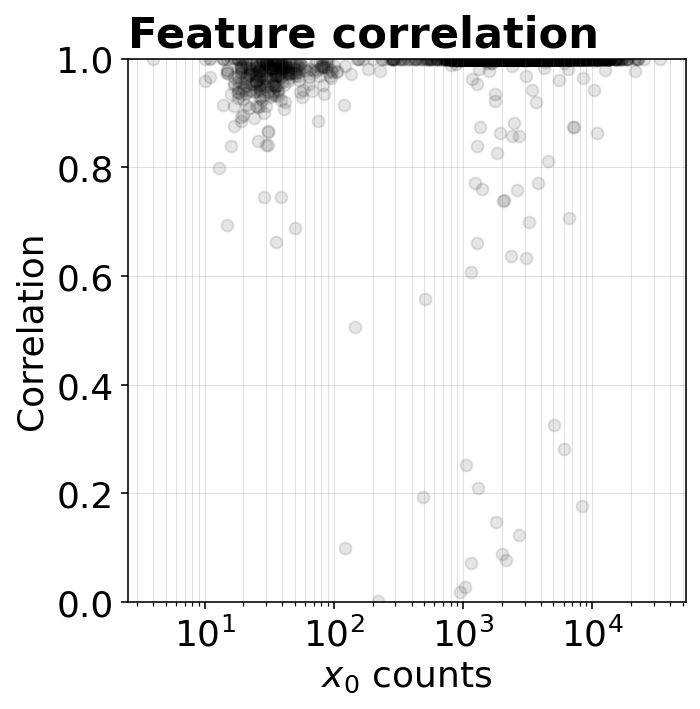

In [44]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cr.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [47]:
# logged counts
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cr.X))
YY_YX = compare.l1_distance(np.log1p(cr.X), np.log1p(kb.X))

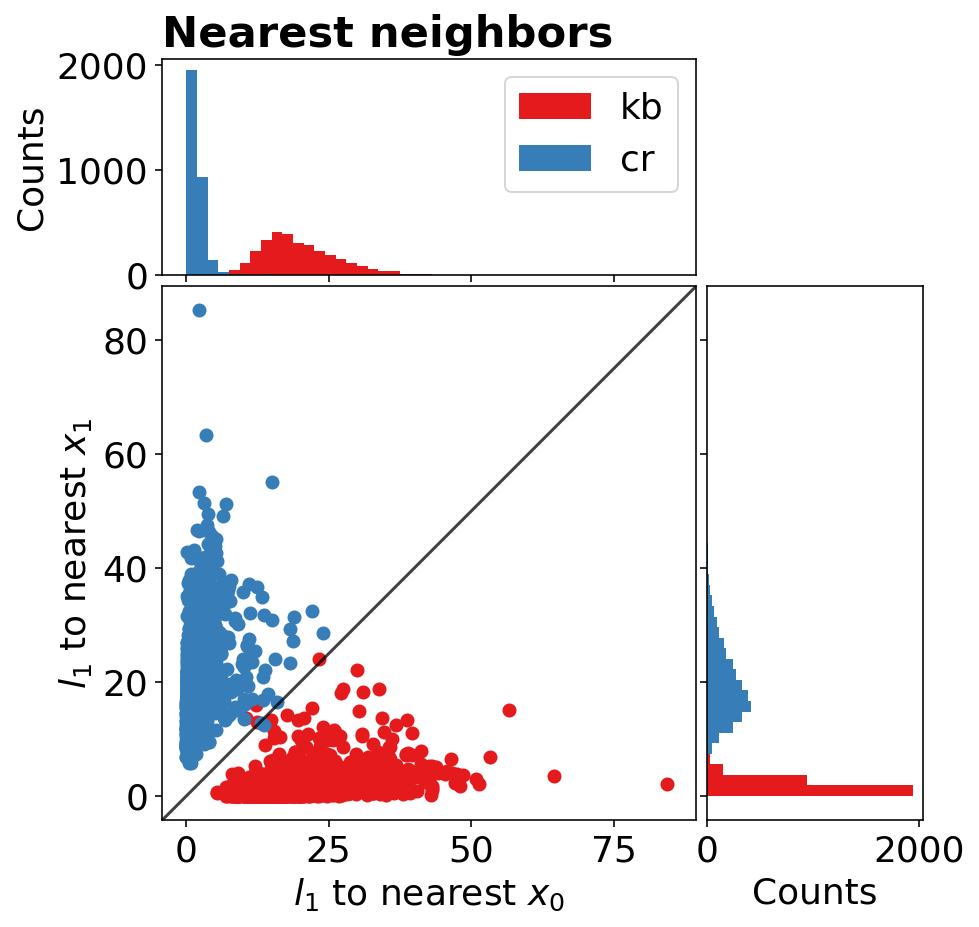

In [48]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [54]:
XX, XY = XX_XY
YY, YX = YY_YX

In [55]:
# logged counts
cnts = compare.sum_features(np.log1p(kb.X), axis=1)

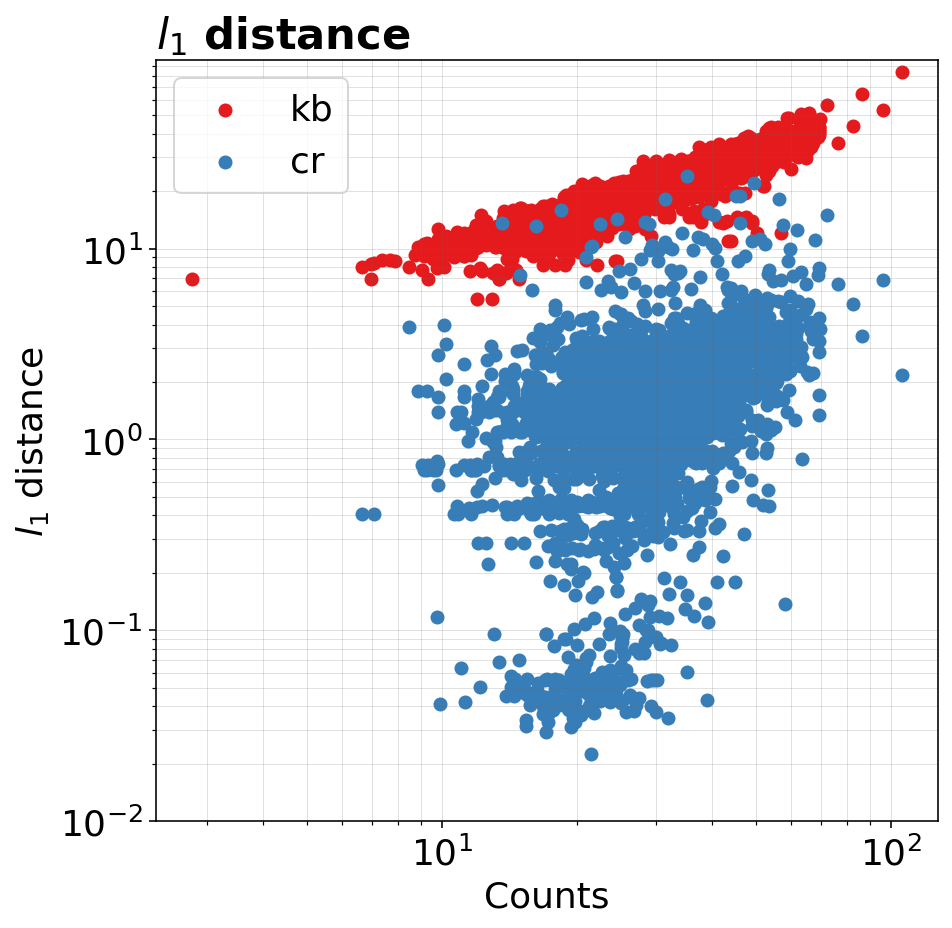

In [59]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)
ax.set(**{"ylim": 0.01})

fig.show()

----------------------------------------